I've noticed that the term machine learning has become increasingly synonymous with deep learning (DL), artificial intelligence (AI) and neural networks (NNs). For example, [posts on the machine learning subreddit almost exclusively relate to neural network based approaches](https://www.reddit.com/r/MachineLearning/comments/6mloim/discussion_is_this_rmachinelearning_or/?st=j50yusg2&sh=68bba8ff) (and [great non-DL posts are not recognised sufficiently for their greatness](https://www.reddit.com/r/MachineLearning/comments/6a94oi/p_unsupervised_machine_learning_explained_with)). So it's time to get on board the hype train! Next stop, Keras! This post is actually relatively basic; [we won't convert photos of horses to photos of zebras](https://github.com/junyanz/CycleGAN), [we won't create jazz music](https://github.com/jisungk/deepjazz). In fact, we won't do anything interesting. We'll just construct a simple Keras model to do basic predictions and illustrate some good practices along the way.

As always, the source code is available from [my Github account](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-09-06-another-keras-tutorial-for-neural-network-beginners.ipynb).

### Motivation

Tensor Flow (TF), Theano, Torch are among the most common deep learning libraries. The differences between each library has been discussed [elsewhere](https://deeplearning4j.org/compare-dl4j-torch7-pylearn). Basically, it comes down to the language in which it was written (i.e. Python, C++, etc.) and the level of abstraction. The last part of that sentence was deliberately vague. Essentially, you want to balance flexibility (customised networks) with readability/interpretation. That's where Keras comes in. I found the TF syntax to be initially a little strange. Keras is effectively a [simplified intuitive API built on top of Tensor Flow or Theano](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html) (you select the backend configuration). So, unless you require that customisation or sophistication that comes with a lower level interface, Keras should be sufficient for your purposes.

Having settled on Keras, I wanted to build a simple NN. I did what any good data scientist does. I searched for a blog post that had already done it so I could just copy and paste the code into my own notebook, run it and then add Keras to my CV. Top of the list was [this post](http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/) from the popular [machinelearningmastery website](http://machinelearningmastery.com/). This website is actually quite an extensive and powerful resource on machine learning, which I certainly recommend. The range of topics covered is extremely impressive (especially next to my record of one post every 3 months). Unfortunately, there's a danger of quantity superseding quality (I ensure quality by posting every 3 months). And that's possibly the case with [its Keras tutorial]((http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/)), as it overlooks fundamental steps in any deep learning model construction (specifically, normalising/scaling the data and splitting the data into separate training, validation and test sets).

In my quest for a more rigorous tutorial, I then stumbled across [this post](https://datanonymous.wordpress.com/using-a-neural-network-to-predict-diabetes-in-pima-indians/), claiming to achieve 95 % accuracy on the same dataset. Being sceptical about this feat, I could see the improvements were realised by expanding the single hidden layer (see cartoon below), with accuracy assessed on the training set. In other words, it was a classic case of overfitting. So, this post is my way to set the record straight and hopefully instill best practices in fellow deep learning newbies.

![More neurons](post_images/more_layers___.png)

I know that cartoon refers to layers (this post will primarily look at neurons), but you get the idea. In machine learning, a little bit of knowledge (and shitloads of neurons) can be a dangerous thing.

### Installing Keras

As Keras is a wrapper for Theano and TensorFlow, you first need to install one of these libraries on your computer (you don't need to install both). You could install them all with one command but it make sense to break up the installation process for debugging purposes. Depending on your operating system, there's extensive installation documentation for both [Theano](http://deeplearning.net/software/theano/install.html) and [TensorFlow](https://www.tensorflow.org/install/). Having installed Theano or TF, from the command line, you can then either install Keras from PyPi or conda if you're working off Anaconda.

![Commands to install Keras](post_images/install_keras.png)

You can check if that all worked by running this short Python code.

In [1]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.0.6


Or from the command line:

![Check if Keras installed successfully](post_images/check_keras.png)

By default, Keras is configured to use a TensorFlow backend. To switch this to Theano, you must locate the Keras configuration file (`$`HOME/.keras/keras.json, where you should change `$`HOME to %USERPROFILE% for Windows users). Just note that the configuration file is created the first time you run Keras. So just change the `backend` value to "theano" (e.g. `$` nano `$`HOME/.keras/keras.json)  and it should be changed the next time you run Keras.

![How to change Keras backend configuration](post_images/change_keras.png)

### Model Construction Basics

Like the posts that motivated this tutorial, I'm going to use the [Pima Indians Diabetes dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/), a standard machine learning dataset with the objective to predict diabetes sufferers. It records various physiological measures of [Pima Indians](https://en.wikipedia.org/wiki/Pima_people) and whether subjects had developed diabetes. At just 768 rows, it's a small dataset, especially in the context of deep learning. But its size will mean that we don't need to worry about things like [batch-size](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network), [CPUs vs GPUs](https://medium.com/@erikhallstrm/hello-world-tensorflow-649b15aed18c) and other computational concerns associated with complex NNs.

We'll load in the dataset from directly from the website. Alternatively, you can download the file [here](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data) and place it in your working directory.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
seed = 155
np.random.seed(seed)

# load pima indians dataset

# download directly from website
dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data", 
                      header=None).values
# import from local directory
#dataset = pd.read_csv("pima-indians-diabetes.data", header=None).values
dataset

array([[   6.   ,  148.   ,   72.   , ...,    0.627,   50.   ,    1.   ],
       [   1.   ,   85.   ,   66.   , ...,    0.351,   31.   ,    0.   ],
       [   8.   ,  183.   ,   64.   , ...,    0.672,   32.   ,    1.   ],
       ..., 
       [   5.   ,  121.   ,   72.   , ...,    0.245,   30.   ,    0.   ],
       [   1.   ,  126.   ,   60.   , ...,    0.349,   47.   ,    1.   ],
       [   1.   ,   93.   ,   70.   , ...,    0.315,   23.   ,    0.   ]])

Okay, we've converted the dataset into a numpy array. The last column indicates whether that person had developed diabetes. Information on the remaining columns is available [here](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names). We must separate the binary classifier and we also need to split the dataset into training and test sets. The original model was trained on 576 rows (or 75 % of the dataset), so we'll retain that convention. For now, we'll just randomly assign 576 rows to the training set, while the remaining rows will constitute the test set. scikit's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function comes in handy here.

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,0:8], dataset[:,8], test_size=0.25, random_state=87)

The data for the model is ready. Now we just need a model. We'll start with a simple single layer fully connected neural network (this is generally not considered deep learning, where deepness is determined by the number of hidden layers). This is pleasingly simple to build in Keras. We just initialise our model and then sequentially add layers (see GIF below). We also need to decide how to assess the accuracy of the model (called loss). As it's a classification problem, [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) is the most appropriate measure of error (a regression task might use mean squared error). A full list of the error functions available with Keras can be found [here](https://keras.io/losses/).

![Stack more layers with Keras](keras/keras_layer_stacking.gif)

In [4]:
np.random.seed(seed)
my_first_nn = Sequential() # create model
my_first_nn.add(Dense(5, input_dim=8, activation='relu')) # hidden layer
my_first_nn.add(Dense(1, activation='sigmoid')) # output layer
my_first_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We don't explicitly create the input layer. Instead, we specify the number of neurons (or features) that feed into the first hidden layer. We also don't need to worry about the input dimensions for subsequent layers, as the neurons in the previous layer form the input for the next layer. We've opted for 10 neurons in the hidden layer for now, but we'll play around this value a little later. Our output has one neuron as it's a binary classification problem (probability of belonging to positive group). 

This a Keras tutorial, so I don't want to spend too long on the NN specific details. The `activation` argument decides (unsurprisingly) the activation function for that layer. A less circular explanation is that activation functions combine the neuron inputs to produce an output. For example, a step function would mean a neuron fires (has a non-zero value) if the input values exceed a certain threshold. Various activation functions are described [here](https://stats.stackexchange.com/questions/115258/comprehensive-list-of-activation-functions-in-neural-networks-with-pros-cons). Finally, you'll notice the optimizer argument is set to `adam`. `adam` stands for Adaptive Moment Estimation; it's how the model tunes its parameters in order to minimise the training error (a good overview of deep learning optimization functions can be found [here](http://ruder.io/optimizing-gradient-descent/)).

Keras allows you to observe the current state of your model at particular points in time, known as [callbacks](https://keras.io/callbacks/). One such callback is a [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint), which we will deploy to write the model parameters to a file. This will allow us to track the improvements in the predictive accuracy of the model on the test set over epochs. Note that this step is optional and can be safely ignored if you're not interested in the performance of your model during intermediate steps. In fact, it's quite a bad habit to compare model characteristics on the test set. Ideally, it should only be deployed at the very end. Think of it like a [bee sting](https://www.thoughtco.com/do-bees-die-after-they-sting-you-1968055) or [the intro to that Eminem song](https://www.youtube.com/watch?v=xFYQQPAOz7Y) or even a Kaggle competition, where you only ever get one shot at the test set.

In [5]:
# optional
from keras.callbacks import ModelCheckpoint
# specify filepath- this will write a new file for each epoch with the epoch number contained within the filename
filepath="nn_weights-{epoch:02d}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, 
                                             save_weights_only=False, save_best_only=False, mode='max')

We're ready to fit our neural network to the training dataset. We pass the model the input and output as separate arguments. We may also specify the batch size (I've gone with a batch equal to the whole training set) and number of epochs (model iterations). More information on the `fit` method can be found [here](https://keras.io/models/model/#fit).

In [6]:
# verbose=0 suppresses the file writing message
# note that the fit method expects a list of callbacks
my_first_nn_fitted = my_first_nn.fit(X_train, Y_train, epochs=1000, verbose=0, batch_size=X_train.shape[0],
                                     callbacks=[checkpoint], initial_epoch=0)

And if you want to assess the performance of your model on the test dataset, use the [evaluate method](https://keras.io/models/model/#evaluate).

In [7]:
# [loss, accuracy]
my_first_nn.evaluate(X_test, Y_test, verbose=0)

[0.59094710648059845, 0.703125]

The values in the list are the model loss and accuracy, respectively. If you're interested in how the training error changed over time, you can call `my_first_nn_fitted.history`.

In [8]:
# training loss and accuracy over the first five epochs
[my_first_nn_fitted.history['loss'][0:5], my_first_nn_fitted.history['acc'][0:5]]

[[4.1766061782836914,
  4.118682861328125,
  4.0560407638549805,
  3.994227409362793,
  3.9317567348480225],
 [0.61284720897674561,
  0.60243058204650879,
  0.59375,
  0.58333331346511841,
  0.57465279102325439]]

You may also want to visualise how the model performed on the test set over time. Remember that we saved the model weights to a file at each epoch.  This means we can reproduce each intermediate model by loading the weights into an appropriately constructed (i.e. same number of layers/neurons) neural network.

In [9]:
temp_test_model = Sequential() # create model
temp_test_model.add(Dense(5, input_dim=8, activation='relu')) # hidden layer
temp_test_model.add(Dense(1, activation='sigmoid')) # output layer
temp_test_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
test_over_time = []
for i in range(len(my_first_nn_fitted.history['acc'])):
    temp_test_model.load_weights("nn_weights-%02d.hdf5" % i)
    scores = temp_test_model.evaluate(X_test, Y_test, verbose=0)
    # 0 is loss; 1 is accuracy
    test_over_time.append(scores)

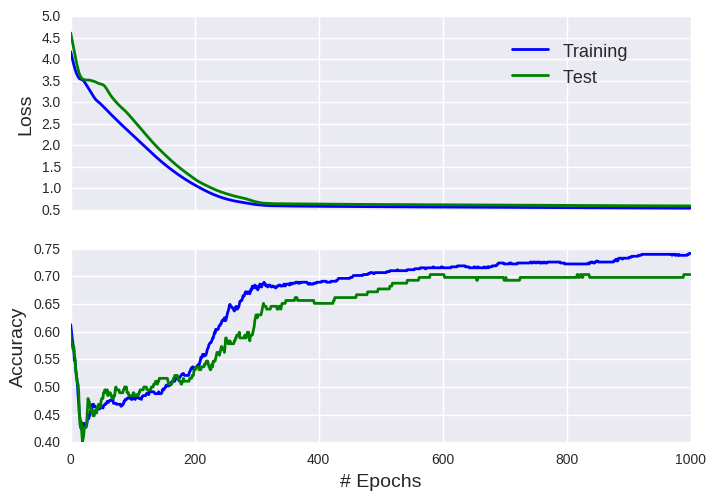

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(my_first_nn_fitted.history['loss'])), my_first_nn_fitted.history['loss'],linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(np.array(test_over_time)[:,0])), np.array(test_over_time)[:,0], linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(my_first_nn_fitted.history['acc'])), my_first_nn_fitted.history['acc'],linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(np.array(test_over_time)[:,1])), np.array(test_over_time)[:,1], linestyle='-', color='green',label='Test', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
#ax1.set_yscale('log')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
plt.show()

Okay, we achieved about 75% accuracy on the training set, which corresponds to 70 % accuracy on the test set. As the performance on the two datasets is not hugely divergent, this suggests that our model does not suffer from significant overfitting. [Recall that 95 % accuracy has been reported on this dataset](https://datanonymous.wordpress.com/using-a-neural-network-to-predict-diabetes-in-pima-indians/), so we still have room for improvement. So how can we improve our basic model? Well, by stuffing more neurons in there, of course! We'll opt for 1000 neurons in a single fully connected hidden layer.

To prevent needless repitition, I'm going to wrap the model construction and performance evaluation in a function.

In [11]:
def runNN(X_train_set, Y_train_set, X_test_set, Y_test_set, n_neurons, n_epochs, seed=155,
          history=True, del_files=True, validation_split=0.0, early_stopping=None):
    np.random.seed(seed)
    nn_model = Sequential() # create model
    nn_model.add(Dense(n_neurons, input_dim=X_train_set.shape[1], activation='relu')) # hidden layer
    nn_model.add(Dense(1, activation='sigmoid')) # output layer
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_callbacks = []
    if early_stopping is not None:
        model_callbacks = [early_stopping]
    if history:
        filepath="nn_weights_%dneurons-{epoch:02d}.hdf5" %n_neurons
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_weights_only=True,
                                     save_best_only=False, mode='max')
        model_callbacks.append(checkpoint)
        output = nn_model.fit(X_train_set, Y_train_set, epochs=n_epochs, verbose=0, 
                              batch_size=X_train_set.shape[0],callbacks=model_callbacks, 
                              initial_epoch=0, validation_split=validation_split).history
        time.sleep(0.1) # hack so that files can be opened in subsequent code
        temp_val_model = Sequential() # create model
        temp_val_model.add(Dense(n_neurons, input_dim=8, activation='relu')) # hidden layer
        temp_val_model.add(Dense(1, activation='sigmoid')) # output layer
        temp_val_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        test_over_time = []
        for i in range(len(output['loss'])):
            temp_val_model.load_weights("nn_weights_%dneurons-%02d.hdf5" % (n_neurons,i))
            scores = temp_val_model.evaluate(X_test_set, Y_test_set, verbose=0)
            test_over_time.append(scores)
            # delete files once we're done with them
            if del_files:
                os.remove("nn_weights_%dneurons-%02d.hdf5" % (n_neurons,i))
        test_over_time = np.array(test_over_time)
        output['test_loss'] = [row[0] for row in test_over_time]
        output['test_acc'] = [row[1] for row in test_over_time]
    else:
        model_output = nn_model.fit(X_train_set, Y_train_set, epochs=n_epochs, verbose=0,
                              batch_size=X_train_set.shape[0],initial_epoch=0,callbacks=model_callbacks,
                              validation_split=validation_split)
        validation_size = 0
        output = {}
        if validation_split>0:
            validation_scores = nn_model.evaluate(model_output.validation_data[0], 
                                             model_output.validation_data[1], verbose=0)
            validation_size = model_output.validation_data[0].shape[0]
            output['validation_loss'] = validation_scores[0]
            output['validation_acc'] = validation_scores[1]
        training_size = X_train.shape[0] - validation_size
        train_scores = nn_model.evaluate(X_train_set[0:training_size], 
                                         Y_train_set[0:training_size], verbose=0)
        test_scores = nn_model.evaluate(X_test_set, Y_test_set, verbose=0)
        output['train_loss'] = train_scores[0]
        output['train_acc'] = train_scores[1]
        output['test_loss'] = test_scores[0]
        output['test_acc'] = test_scores[1]
    return output

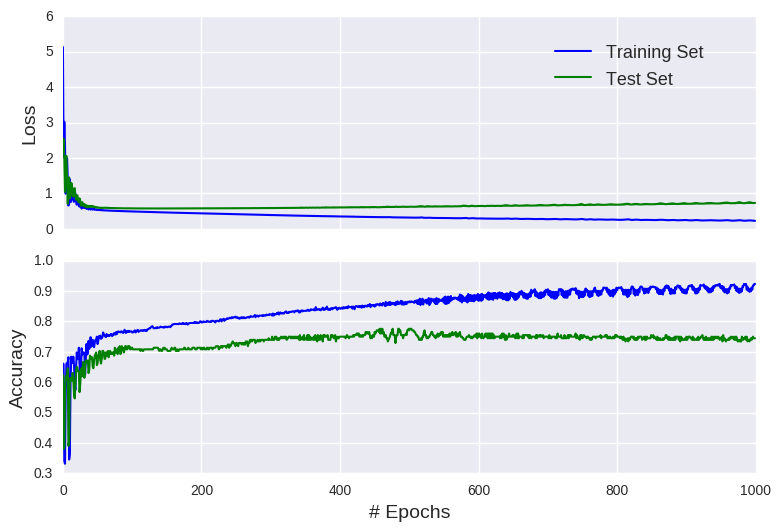

In [12]:
my_second_nn = runNN(X_train, Y_train, X_test, Y_test, 1000, 1000)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(my_second_nn['loss'])),my_second_nn['loss'], color='blue',label='Training Set', lw=1.5)
ax1.plot(range(len(my_second_nn['test_loss'])),my_second_nn['test_loss'], color='green',label='Test Set', lw=1.5)
ax2.plot(range(len(my_second_nn['acc'])),my_second_nn['acc'], color='blue',label='Training Set', lw=1.5)
ax2.plot(range(len(my_second_nn['test_acc'])),my_second_nn['test_acc'], color='green',label='Test Set', lw=1.5)
leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
plt.tight_layout()
plt.show()

You'll notice a gradual reduction in the training error, without any corresponding improvement in the test prediction (it actually appears to get worse). This represents textbook overfitting. Our neural network model has fine-tuned its parameters to the training dataset, so that it performs poorly on any unseen data. In other words, the model is highly specialised to the training set and doesn't generalise well beyond the training data. It's analogous to including more complex interaction terms in a simple regression task (also known as the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)). A [good analogy](https://dswalter.github.io/blog/overfitting-regularization-hyperparameters/) is a model that's trained to detect a specific species of bird. The more it trains, its ability to detect other bird species worsens.

You may also notice that we didn't achieve our target of 95 % accuracy on the training set. It's possible that we would eventually hit this target if the model was allowed more time to improve itself. As the model has 9000 parameters (8x1000+ 1x1000), it can take many epochs to find every marginal gain. We could also decide to play around with the [learning rate](http://cs231n.github.io/neural-networks-3/). But the model possesses an inherent flaw. The data was not scaled and/or normalised. Scaling/normalising the data traditionally involves linear transformation to force all values within a specific interval (e.g. between 0 and 1), while [standardising](https://stats.stackexchange.com/questions/10289/whats-the-difference-between-normalization-and-standardization) typically transforms the inputs to have the mean centred on zero with unit variance. Either way, no input feature dominates the model and this forces consistent weights. For example, 5000 x 0.0002 = 2 x 0.5, so that weights differ by several orders of magnitude, which could inhibit backpropagation.

Scaling/normalising is easy; we can just employ some tools from scikit-learn. Note that you should scale/normalise the training and test sets separately. Otherwise, you'd be using information from your test set to inform your model training (if in doubt, [think what would Eminem do?]([that Eminem song](https://www.youtube.com/watch?v=xFYQQPAOz7Y)). We'll opt for the unit variance with the mean centred on 0 approach.

In [13]:
scaler = StandardScaler()
nn_output_unscaled = runNN(X_train, Y_train, X_test, Y_test, 1000, 1000)
nn_output_scaled = runNN(scaler.fit_transform(X_train), Y_train, 
                         scaler.fit_transform(X_test), Y_test, 1000, 1000)

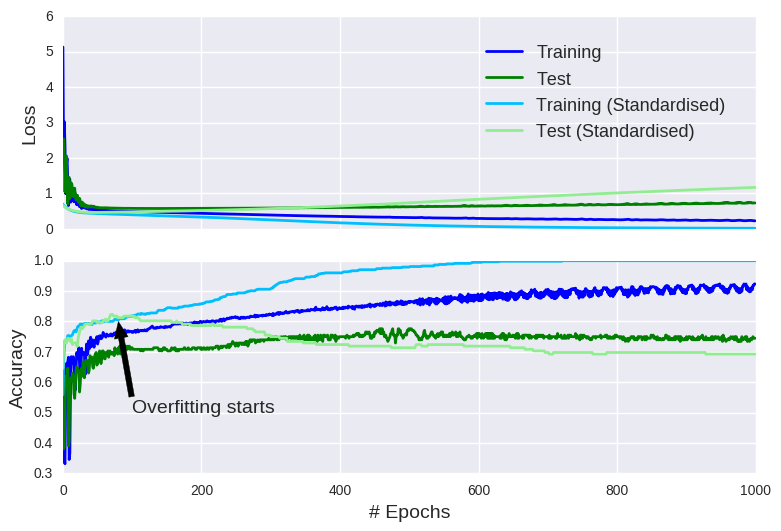

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(nn_output_unscaled['loss'])), nn_output_unscaled['loss'], linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(nn_output_unscaled['test_loss'])), nn_output_unscaled['test_loss'], linestyle='-', color='green',label='Test', lw=2)
ax1.plot(range(len(nn_output_scaled['loss'])), nn_output_scaled['loss'], linestyle='-', color='deepskyblue',label='Training (Standardised)', lw=2)
ax1.plot(range(len(nn_output_scaled['test_loss'])), nn_output_scaled['test_loss'], linestyle='-', color='lightgreen',label='Test (Standardised)', lw=2)
ax2.plot(range(len(nn_output_unscaled['acc'])), nn_output_unscaled['acc'], linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(nn_output_unscaled['test_acc'])), nn_output_unscaled['test_acc'], linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(nn_output_scaled['acc'])), nn_output_scaled['acc'], linestyle='-', color='deepskyblue',label='Training (Standardised)', lw=2)
ax2.plot(range(len(nn_output_scaled['test_acc'])), nn_output_scaled['test_acc'], linestyle='-', color='lightgreen',label='Test (Standardised)', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.6, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
ax2.annotate('Overfitting starts', xy=(80, 0.8), xytext=(100, 0.5),fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.0,headwidth=10))
plt.tight_layout()
plt.show()

In [15]:
nn_output_scaled['acc'][-1]

1.0

We did it! By normalizing the input data, we surpassed that 95% accuracy benchmark and even attained perfect accuracy on the training set. Maybe if we added more neurons, we could defy mathematical logic and beat perfection. Mo' neurons, mo' money! However, as the training error on the standardised inputs approached zero, the test error showed no improvement. In fact, it even appears to significantly worsen. In other words, we have another case of overfitting. On a positive note, this graph also demonstrates the benefits of standardising your input data (as long as you don't allow the model overfit).

# Validation Set & Early Stopping

Remember, a good model is one that generalises well to unseen data. As such, reductions in the training error are only beneficial if they coincide with improvements in the test accuracy. Ideally, we'd stop training the model when it's no longer improving the test accuracy (known as [early stopping](https://en.wikipedia.org/wiki/Early_stopping)). This is the reasoning behind the validation set. During the training phase, the model parameters (node weights in the case of NNs) are tuned on the training data, while the accuracy of the model is regularly assessed on data that sits outside of the training data (i.e. the validation set). As long as the validation error is decreasing, the model can continue to fine tune its parameters. Though they may seem to conceptually fulfill the same role, just beware that the validation and test datasets should be strictly separated. As model training incorporated the validation set, predictive performance can only be determined on the test set (hence, the training/validation/test split convention).

In Keras, we have two options to include a validation set. We can directly pass a validation set (inputs and labels separately). Alternatively, we can extract a subset of the training set (specified as a proportion of the training set- [Keras will simply take the last n% of the training set](https://keras.io/getting-started/faq/#how-is-the-validation-split-computed)). If you opt for the latter option, you may want to [shuffle your training set](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.shuffle.html), if you suspect row position is not purely random. For reasons of brevity, we'll assume that's not case here. To incorporate early stopping, we add an [EarlyStopping](https://keras.io/callbacks/#earlystopping) callback to our model.

As I cleverly anticipated that I would discuss early stopping, we can use the `runNN` function. We just need to specify the validation split (early stopping requires some type of validation set) and our early stopping criteria. I'm going to be patient and offer the model 20 epochs to demonstrate a reduction in the validation loss (you can define what qualifies as a reduction using the `monitor` and `min_delta` arguments). We'll define the validation set to be the last 20% of the training set, creating a 60/15/25 split.

In [16]:
early_stop_crit = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                patience=20, verbose=0, mode='auto')
nn_output_unscaled = runNN(X_train, Y_train, X_test, Y_test, 1000, 1000,
                                         validation_split=0.2, early_stopping=early_stop_crit)
nn_output_scaled = runNN(scaler.fit_transform(X_train), Y_train, scaler.fit_transform(X_test), 
                         Y_test, 1000, 1000,validation_split=0.2, early_stopping=early_stop_crit)

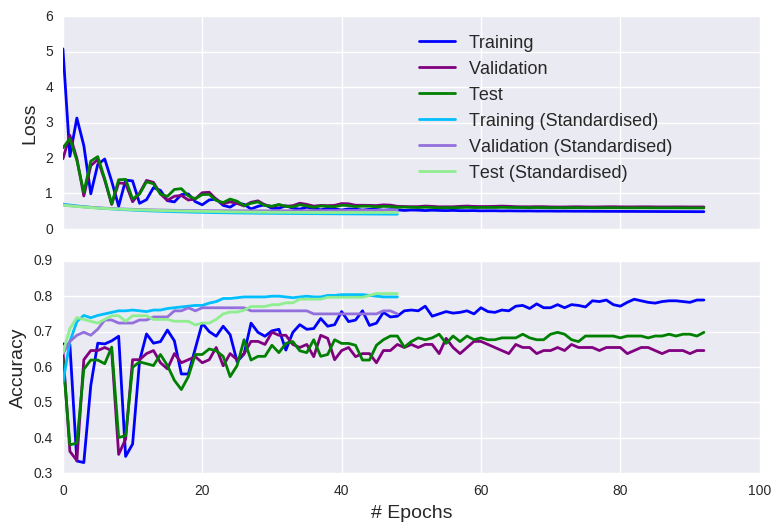

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(nn_output_unscaled['loss'])), nn_output_unscaled['loss'], linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(nn_output_unscaled['val_loss'])), nn_output_unscaled['val_loss'], linestyle='-', color='purple',label='Validation', lw=2)
ax1.plot(range(len(nn_output_unscaled['test_loss'])), nn_output_unscaled['test_loss'],linestyle='-', color='green',label='Test', lw=2)
ax1.plot(range(len(nn_output_scaled['loss'])), nn_output_scaled['loss'], linestyle='-', color='deepskyblue',label='Training (Standardised)', lw=2)
ax1.plot(range(len(nn_output_scaled['val_loss'])), nn_output_scaled['val_loss'], linestyle='-', color='mediumpurple',label='Validation (Standardised)', lw=2)
ax1.plot(range(len(nn_output_scaled['test_loss'])), nn_output_scaled['test_loss'], linestyle='-', color='lightgreen',label='Test (Standardised)', lw=2)
ax2.plot(range(len(nn_output_unscaled['acc'])), nn_output_unscaled['acc'], linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(nn_output_unscaled['val_acc'])), nn_output_unscaled['val_acc'], linestyle='-', color='purple',label='Validation', lw=2)
ax2.plot(range(len(nn_output_unscaled['test_acc'])), nn_output_unscaled['test_acc'],linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(nn_output_scaled['acc'])), nn_output_scaled['acc'], linestyle='-', color='deepskyblue',label='Training (Standardised)', lw=2)
ax2.plot(range(len(nn_output_scaled['val_acc'])), nn_output_scaled['val_acc'], linestyle='-', color='mediumpurple',label='Validation (Standardised)', lw=2)
ax2.plot(range(len(nn_output_scaled['test_acc'])), nn_output_scaled['test_acc'], linestyle='-', color='lightgreen',label='Test (Standardised)', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.5, 0.95), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
plt.tight_layout()
plt.show()

As well as preventing overfitting, one obvious advantage of early stopping is that it allows the model to stop early. You won't find that kind of insight on [machinelearningmastery](https://machinelearningmastery.com/)!!! While it may not appear hugely beneficial for our small simplified model, in the world of deep learning and driverless cars, this could save you some time. Of course, early stopping raises the prospect of premature stopping (i.e. terminating the training phase at a sub-optimal configuration). This risk can be mitigated by increasing the `patience` argument or loosening your definition of an improvement. As an aside, note the erratic behaviour exhibited by the model trained on unscaled data, which can be attributed to the instability of gradients derived from highly unbalanced input values.

# Hyperparameter Tuning (& Cross-Validation)

Hopefully, you've realised that less is sometimes more. Iterating over fewer epochs can actually improve the predictive power of the model. How about the number of nodes in the single hidden layer? Surely, we should just cramming them in there. Right? Well, this is known as hyperparamater tuning/optimisation- as opposed to parameter tuning, which is changing the model weights during the training phase. We can run multiple models with varying number of nodes (which we specify) and accept the version that performs best on the validation set. This is known as grid search (we're searching over a grid of values... yet more insightful insights you won't find anywhere else). Note that the process is similar if you want to tune other model hyperparameters (e.g. learning rate, batch size, activation functions, etc.). I'm actually going to compare the models on loss rather than accuracy; though it's less intuitive, it is more informative (an improvement in model loss doesn't necessarily coincide with better accuracy).

In [18]:
my_grid=[2,3,5,10,20,50,100,200,500,1000,5000]
nn_outputs = []
nn_outputs_early = []
early_stop_crit = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                                patience=20, verbose=0, mode='auto')
for i in my_grid:
    print(i)
    nn_output_unscaled = runNN(X_train, Y_train, X_test, Y_test, i, 1000, history=False)
    nn_output_scaled = runNN(scaler.fit_transform(X_train), Y_train,
                              scaler.fit_transform(X_test), Y_test, i, 1000, history=False)
    nn_output_unscaled_early = runNN(X_train, Y_train, X_test, Y_test, i, 1000, history=False,
                                   validation_split=0.2, early_stopping=early_stop_crit)
    nn_output_scaled_early = runNN(scaler.fit_transform(X_train), Y_train,
                                   scaler.fit_transform(X_test), Y_test, i, 1000, history=False,
                                   validation_split=0.2, early_stopping=early_stop_crit)
    nn_outputs.append([i, nn_output_unscaled['train_loss'],nn_output_unscaled['test_loss'], 
                       nn_output_scaled['train_loss'], nn_output_scaled['test_loss']])
    nn_outputs_early.append([i, nn_output_unscaled_early['train_loss'],nn_output_unscaled_early['validation_loss'],
                             nn_output_unscaled_early['test_loss'], nn_output_scaled_early['train_loss'], 
                             nn_output_scaled_early['validation_loss'], nn_output_scaled_early['test_loss']])
nn_outputs = np.array(nn_outputs)   
nn_outputs_early = np.array(nn_outputs_early)   

2
3
5
10
20
50
100
200
500
1000
5000


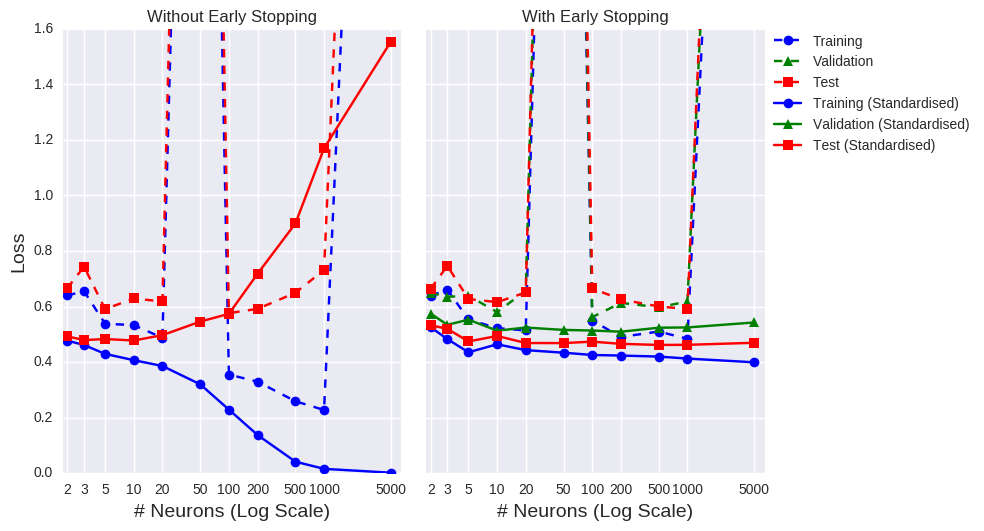

In [19]:
import matplotlib.ticker
from matplotlib.ticker import NullFormatter

fig1, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(nn_outputs[:,0], nn_outputs[:,1], '--bo',label='Training', ms=7)
ax1.plot(nn_outputs[:,0], nn_outputs[:,2],  '--rs',label='Test', ms=7)
ax1.plot(nn_outputs[:,0], nn_outputs[:,3], '-bo',label='Training (Standardised)', ms=7)
ax1.plot(nn_outputs[:,0], nn_outputs[:,4],  '-rs',label='Test (Standardised)', ms=7)
ax1.set_xscale('log')
ax1.set_xticks([2,3,5,10,20,50,100,200,500,1000,5000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_ylim([0,1.6])
ax1.set_xlim([1.8,6500])
ax1.set_ylabel('Loss',size=14)
ax2.plot(nn_outputs_early[:,0], nn_outputs_early[:,1], '--bo',label='Training', ms=7)
ax2.plot(nn_outputs_early[:,0], nn_outputs_early[:,2],  '--g^',label='Validation', ms=7)
ax2.plot(nn_outputs_early[:,0], nn_outputs_early[:,3], '--rs',label='Test', ms=7)
ax2.plot(nn_outputs_early[:,0], nn_outputs_early[:,4],  '-bo',label='Training (Standardised)', ms=7)
ax2.plot(nn_outputs_early[:,0], nn_outputs_early[:,5], '-g^',label='Validation (Standardised)', ms=7)
ax2.plot(nn_outputs_early[:,0], nn_outputs_early[:,6],  '-rs',label='Test (Standardised)', ms=7)
ax2.set_xscale('log')
ax2.set_xticks([2,3,5,10,20,50,100,200,500,1000,5000])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylim([0,1.6])
ax2.set_xlim([1.8,6500])
ax1.set_xlabel('# Neurons (Log Scale)',size=14)
ax2.set_xlabel('# Neurons (Log Scale)',size=14)
ax1.set_title('Without Early Stopping')
ax2.set_title('With Early Stopping')
ax2.yaxis.set_major_formatter(NullFormatter())
plt.tight_layout()
ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.show()

In [20]:
# number of neurons with lowest validation loss on the standardised inputs
my_grid[np.argmin(nn_outputs_early[:,5])]

200

The graph on the left doesn't include a validation set or early stopping. We can clearly see that standardising the data improves the model performance (last time I mention this, I promise!) and that more neurons doesn't necessarily equate to improved accuracy. Similar to training over endless epochs, more neurons just offers more opportunities to overfit the training data. Astute readers may have noticed spikes at 50 and 5000 neurons for the unscaled dataset (which are literally off the charts!!!). Remember that NN weights are usually randomly initialised (typically uniformly distributed but there are [various alternatives](https://keras.io/initializers/)). It's possible that a model was handed a bad set of initial weights (think trying to reach the mountaintop if you start in a flat valley). What we could do is take the best score across a number of executions (by changing the seed), though it seems that standardising your inputs is a sufficient defence against an unlucky start.

If we add a validation set and allow early stopping (the graph on the right), we notice that the gap between the training accuracy and test accuracy is much narrower (indicative of reduced overfitting). Remember, we're trying to find the optimal number of neurons to include in the hidden layer. Ignoring the unscaled data from now on (I think I've made my point), we should opt for the value that returns the highest validation score. Using the test data here would be a form of cheating- remember we don't want the test data to inform the model. In that case, we'd settle on 200 neurons. But this was just one model execution, with the validation set comprising the last 20% of the training set. What would happen if the validation set was formed by the first 20%? We might well get a completely different answer. This the reasoning behind [k-fold cross-validation](http://bit.ly/2cEQ6Oz). We'll run the model five times (hence, 5-fold cross-validation), taking non-overlapping 20% chunks for the validation set each time. The hyperparameter with the lowest average loss (or highest average accuracy, if you prefer) across those folds is deemed the winner.

Rather than manually constructing the cross-validation datasets, we can harness the power (and convenience) of scikit-learn. We'll employ [stratified cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), which aims to replicate the label balance across each fold. I should point out that keras and scikit provides an [elegant interface to combine grid search and cross-validation for hyperparameter tuning](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/); I've seperated the processes for illustrative purposes.

In [21]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
all_kfolds_results=[]
for grid_vals in my_grid:
    kfolds_results = []
    print(grid_vals)
    for train_set, validation_set in kfold.split(X_train, Y_train):
        kfolds_results.append(runNN(scaler.fit_transform(X_train[train_set]), Y_train[train_set],
                                    scaler.fit_transform(X_train[validation_set]), Y_train[validation_set],
                                    grid_vals, 1000, history=False, validation_split=0.2,
                                    early_stopping=early_stop_crit)['test_loss'])
    all_kfolds_results.append(kfolds_results)

2
3
5
10
20
50
100
200
500
1000
5000


![title](x-validation/cross_validation.gif)

In [22]:
my_grid[np.argmin(np.mean(all_kfolds_results,axis=1))]

200

Looking at the averages alone, we'd conclude that 200 neurons is optimal. Those error bars represent the standard deviation, which measures the statistical uncertainty around those means. I won't delve into hypothesis testing ([the merits of which can be debated](https://stats.stackexchange.com/questions/185048/should-repeated-cross-validation-be-used-to-assess-predictive-models?rq=1])), but superficially we can see that most of those errors bars overlap, meaning there's very little significant difference between each case (don't put that sentence in your paper submission). The size of the bars is worth noting, as it measures model stability. Depending on your circumstances, rather than overall accuracy, you may prefer a model that performs well consistently (small bars), as that could indicate it's more likely to maintain its performance on unseen data.

Before you seek out an [online t-test calculator](https://www.graphpad.com/quickcalcs/ttest1.cfm), it's worth noting that the training/validation split can be sliced and diced in a whole multitude of ways (${{576}\choose{115}}> 4\times10^{123}$). So far, we've assessed the hyperparameters on a single 5-fold cross validation configuration. Obviously, I don't recommend exhausting the full array of potential cross-validations, but it's good practice to compare your models across a number of different splits (called repeated cross-validation). Simply call [RepeatedStratifiedKfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) and specify the number of repeats. To illustrate it in action, I'll opt for 4 repeats (in practice, [you'd probably want to increase this number](https://stats.stackexchange.com/questions/82546/how-many-times-should-we-repeat-a-k-fold-cv)).

In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold
# repeated stratified cross-validation
# only available with scikit-learn v0.19.0
# check your version:
# print('The scikit-learn version is {}.'.format(sklearn.__version__))
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=seed)
all_kfolds_results = []
for grid_vals in my_grid:
    kfolds_results = []
    print(grid_vals)
    for train_set, validation_set in rkf.split(X_train, Y_train):
        kfolds_results.append(runNN(scaler.fit_transform(X_train[train_set]), Y_train[train_set],
                                        scaler.fit_transform(X_train[validation_set]), Y_train[validation_set],
                                        grid_vals, 1000, history=False, validation_split=0.2,
                                        early_stopping=early_stop_crit)['test_loss'])
    all_kfolds_results.append(kfolds_results)
#all_kfolds_results = np.load('all_kfolds_results_repeat_xval.npy')

2
3
5
10
20
50
100
200
500
1000
5000


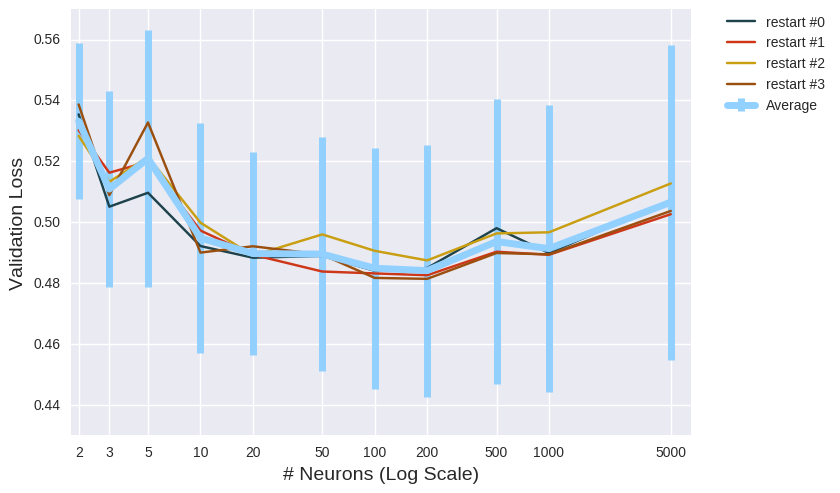

In [30]:
import matplotlib.ticker
import matplotlib.pyplot as plt


fig1, ax1 = plt.subplots()
for i, my_col in zip(range(4),['#1E434C','#ce3618','#C99E10','#9B4F0F']):
    plt.plot(my_grid, np.mean(np.array(all_kfolds_results)[:,range(i*5,(i+1)*5)],axis=1), 
                 label='restart #%d'%i, ms=7, color=my_col)
plt.errorbar(my_grid, np.mean(np.array(all_kfolds_results),axis=1), 
                 yerr=np.std(np.array(all_kfolds_results),axis=1),label='Average', ms=20,lw=5,color='#91d0ff')
plt.xscale('log')
plt.xticks([2,3,5,10,20,50,100,200,500,1000,5000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_ylim([0.43,0.57])
ax1.set_xlim([1.8,6500])
ax1.set_xlabel('# Neurons (Log Scale)',size=14)
ax1.set_ylabel('Validation Loss',size=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [25]:
my_grid[np.argmin(np.mean(np.array(all_kfolds_results),axis=1))]

200

It's a close contest but a hidden layer with 200 neurons is the winner. We could shorten those error bars (and potentially get a different winner) by performing more repeats, but that's sufficient for my purposes.

Finally, we can answer the age old question of the optimal number of neurons to put into a single hidden layer feed forward neural network model to predict diabetes sufferers among Pima Indians. It's 200... Or maybe 100. But it's certainly within those two numbers. Ah actually, that's not necessarily true. I need to look at 250. And 201...

# Summary

This post was much more detailed (and wordy) than I had initially planned. Who knew there were so many ways to mess up a neural net? If you intend to actually gain some meaningful insights from your model (could happen...), then here are my top tips:

* Construct sensible training/validation/test splits
* Scale/Normalise/Standardise your input data
* Include early stopping to prevent overfitting ([dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) could also work here)
* If conducting hyperparameter optimisation, select model with best performance on the validation set from repeated cross-validation
* Evaluate model on test set

Thanks for reading!!! I need to lie down.

# Source Code

The original code is available as a Jupyter notebook [here](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-09-06-another-keras-tutorial-for-neural-network-beginners.ipynb).

# Appendix

The code to produce those gifs is included below. Give a man a gif and he'll read your blog once, teach a man to gif and you'll attract many new readers (assuming your original code is adaquately linked).

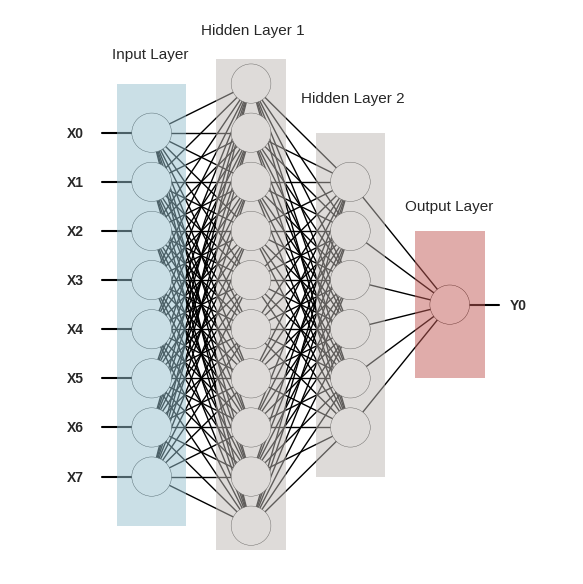

In [26]:
import matplotlib.patches as patches

num_plot = 0
input_n = 8
input_cens = [0.5*i for i in range(input_n)]
# hl refers to hidden layer
hl0_n = 10
hl0_cens = [0.5*i-0.5 for i in range(hl0_n)]
hl1_n = 6
hl1_cens = [0.5*i+0.5 for i in range(hl1_n)]
output_n = 1
out_cens = np.mean(input_cens)
fig1, ax1 = plt.subplots()
fig1.set_size_inches(6, 6)
ax1.set_ylim([-0.75,4.75])
ax1.set_xlim([-0.75,4.75])
ax1.axison=False
plt.tight_layout()
for input_num,input_cen in enumerate(input_cens):
    ax1.add_artist(plt.Circle((0.5, input_cen), 0.2,  color='w', ec='k',clip_on=True, zorder=1))
    for hl0_cen in hl0_cens:
        plt.plot([0.5,1.5],[input_cen, hl0_cen],linestyle='-', color='black',label='Training', lw=1, zorder=0)
for hl0_cen in hl0_cens:
    ax1.add_artist(plt.Circle((1.5, hl0_cen), 0.2,  color='w', ec='k',clip_on=True, zorder=1))
plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
for input_num,input_cen in enumerate(input_cens):
    plt.plot([0,0.5], [input_cen,input_cen],linestyle='-', color='black',lw=1.5, zorder=0)
    ax1.text(-0.35, input_cen-0.05, 'X%d'%(input_n-input_num-1), fontsize=10, fontweight='bold')
plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
ax1.add_artist(patches.Rectangle((0.15, -0.5), 0.7, 4.5,alpha=0.5,linewidth=0,color='#96C0CE'))
ax1.text(0.1, 4.25, 'Input Layer', fontsize=11)
plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
ax1.add_artist(patches.Rectangle((1.15, -1), 0.7, 5.25,alpha=0.5,linewidth=0,color='#BEB9B5'))
ax1.text(1, 4.5, 'Hidden Layer 1', fontsize=11)
plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
for hl0_cen in hl0_cens:
    for hl1_cen in hl1_cens:
        plt.plot([1.5,2.5],[hl0_cen, hl1_cen],linestyle='-', color='black',label='Training', lw=1, zorder=0)
for hl1_cen in hl1_cens:
    ax1.add_artist(plt.Circle((2.5, hl1_cen), 0.2,  color='w', ec='k',clip_on=True, zorder=1))

plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
ax1.add_artist(patches.Rectangle((2.15, 0), 0.7, 3.5,alpha=0.5,linewidth=0,color='#BEB9B5'))
ax1.text(2, 3.8, 'Hidden Layer 2', fontsize=11)
plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
for hl1_cen in hl1_cens:
    for out_cen in [out_cens]:
        plt.plot([2.5,3.5],[hl1_cen, out_cen],linestyle='-', color='black',label='Training', lw=1, zorder=0)
for out_cen in [out_cens]:
    ax1.add_artist(plt.Circle((3.5, out_cen), 0.2,  color='w', ec='k',clip_on=True, zorder=1))
plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
ax1.add_artist(patches.Rectangle((3.15, 1), 0.7, 1.5,alpha=0.5,linewidth=0,color='#C25B56'))
ax1.text(3.05, 2.7, 'Output Layer', fontsize=11)
plt.savefig('keras_nns_%d.png'%num_plot)
num_plot = num_plot + 1
plt.plot([3.5,4], [out_cen,out_cen],linestyle='-', color='black',lw=1.5, zorder=0)
ax1.text(4.1, 1.7, 'Y0', fontsize=10, fontweight='bold')
plt.savefig('keras_nns_%d.png'%num_plot)
plt.show()

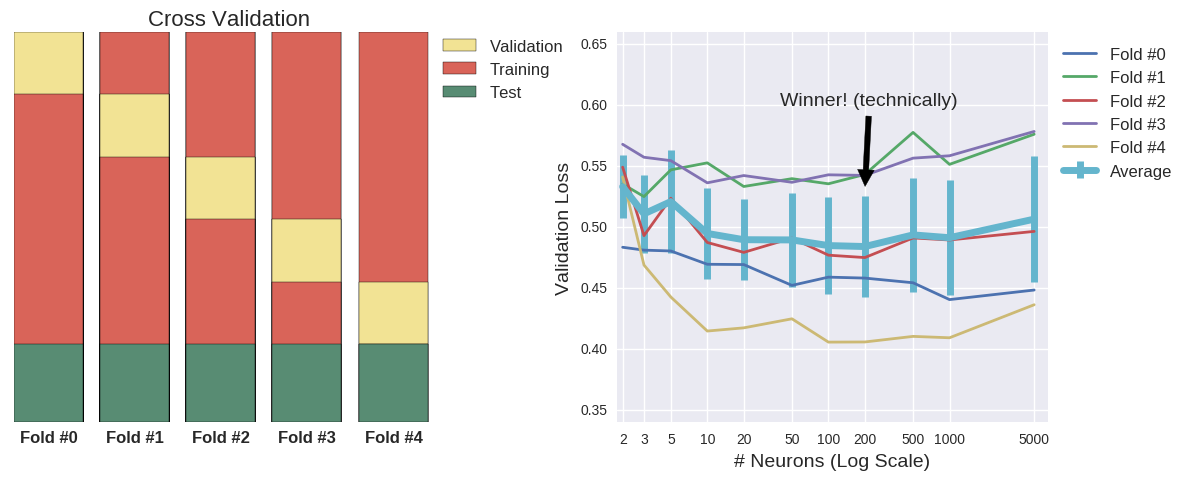

In [32]:
nfolds=5
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
fig.subplots_adjust(wspace=0.3)
ax1.set_yticks([])
ax1.set_xlim(0,5)
ax1.axison=False
#ax1.set_xticks([i+0.4 for i in nfolds], ['Fold #%d'%i for i in range(5)])
#ax1.text(0, -5, 'Fold #0', fontsize=12, fontweight='bold')
ax1.set_axis_bgcolor("white")
ax1.set_title('Cross Validation',size=16)
ax2.set_xscale('log')
ax2.set_xticks(my_grid)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylim([0.34,0.66])
ax2.set_xlim([1.8,6500])
ax2.set_xlabel('# Neurons (Log Scale)',size=14)
ax2.set_ylabel('Validation Loss',size=14)
plt.tight_layout()
fig.subplots_adjust(wspace=0.4)
plt.subplots_adjust(right=0.88)
for nn in range(1,6):
    p00=ax1.bar(range(nn), [100. for i in range(nn)], color = '#D96459')
    p0=ax1.bar(range(nn), [100-16*i for i in range(nn)], color = '#F2E394')
    p1=ax1.bar(range(nn), [100-16*(i+1) for i in range(nn)], color = '#D96459')
    p2=ax1.bar(range(nn), [20. for i in range(nn)], color = '#588C73')
    ax1.legend((p0[0], p1[0], p2[0]), ('Validation', 'Training', 'Test'),bbox_to_anchor=(0.98, 1), loc=2, 
           borderaxespad=0.,prop={'size': 12})
    ax1.text(nn-0.93, -5, 'Fold #%d'%(nn-1), fontsize=12, fontweight='bold')
    plt.savefig('x-valid_%d.png'%nn)
    ax2.plot(my_grid, np.transpose(all_kfolds_results)[nn-1],ms=7,label='Fold #%d'%(nn-1),lw=2)
    ax2.legend(bbox_to_anchor=(1.0, 1), loc=2, prop={'size': 12})
    plt.savefig('x-valid_%d_.png'%nn)
ax2.errorbar(my_grid, np.mean(all_kfolds_results,axis=1), 
                  yerr=np.std(all_kfolds_results,axis=1),label='Average', ms=20,lw=5)
ax2.legend(bbox_to_anchor=(1.0, 1), loc=2, prop={'size': 12})
plt.savefig('x-valid_%d_.png'%(nfolds+1))
ax2.annotate('Winner! (technically)', xy=(200, 0.53), xytext=(40, 0.6),fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.savefig('x-valid_%d__.png'%(nfolds+1))
plt.show()